# Programming in the Scientific Environment 

## Aplications to Astrophysics II. astropy


astropy is a collection of packages with basic tools to work in Astrophysics with Python.

Installation with Conda: astropy is a one of the default packages of the Anaconda environment. To update the latest version:

       conda update astropy

Installation with Pip:
        
        pip install astropy




Documentation:

https://docs.astropy.org/en/stable/index.html


Simple examples using the astropy module. This notebook shows examples of:
  
  * Reading/writing FITS files
  * Cosmological calculations

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

### Reading/writing FITS files

In [4]:
from astropy.io import fits

In [64]:
# Example of FITS file
filename = 'signal_sky_components.fits'

hdul = fits.open(filename) 
hdul.info()

Filename: signal_sky_components.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  CMB           1 ImageHDU        13   (49152, 3, 15)   float64   
  2  SYNCHROTRON    1 ImageHDU        13   (49152, 3, 15)   float64   
  3  DUST          1 ImageHDU        13   (49152, 3, 15)   float64   


In [6]:
hdul[2].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                49152                                                  
NAXIS2  =                    3                                                  
NAXIS3  =                   15                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SYNCHROTRON'        / extension name                                 
AXIS1   = 'NU      '           /  GHz                                           
AXIS2   = 'IQU     '           / Stokes Parameters                              
AXIS3   = 'Npix    '           / 12*nside^2                                     
NU      = '40 50 60 68 78 89

/Users/elenadelahoz/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:209: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds


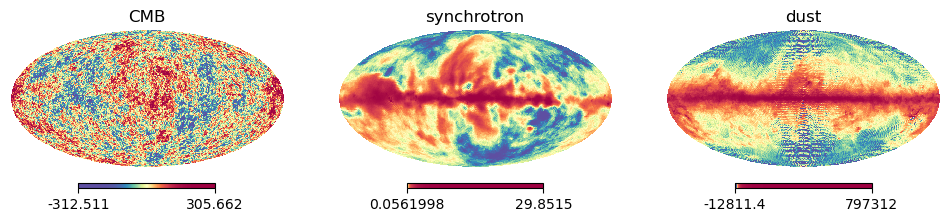

In [7]:
import healpy as hp

ind_nu = np.random.choice((hdul[1].data).shape[0])
ind_sp = 0

fig, axes = plt.subplots(ncols=3,figsize=(12,4), dpi= 100)

plt.axes(axes[0])
hp.mollview(hdul[1].data[ind_nu,ind_sp],title='CMB',hold=True, cmap='Spectral_r', norm='hist')

plt.axes(axes[1])
hp.mollview(hdul[2].data[ind_nu,ind_sp],title='synchrotron', cmap='Spectral_r', hold=True, norm='hist')

plt.axes(axes[2])
hp.mollview(hdul[3].data[ind_nu,ind_sp],title='dust', cmap='Spectral_r', hold=True,norm='hist')

In [8]:
cmb_maps = hdul[1].data
synchrotron_maps = hdul[2].data
dust_maps = hdul[3].data

hdul.close()

In [9]:
from astropy.utils.data import download_file
image_file = download_file('http://data.astropy.org/tutorials/FITS-images/HorseHead.fits', cache=True )


with fits.open(image_file) as hdul:
    hdul.info()

Filename: /Users/elenadelahoz/.astropy/cache/download/url/ff6e0b93871033c68022ca026a956d87/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     161   (891, 893)   int16   
  1  er.mask       1 TableHDU        25   1600R x 4C   [F6.2, F6.2, F6.2, F6.2]   


<class 'numpy.ndarray'>
(893, 891)


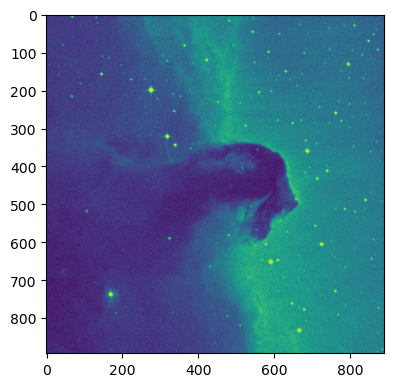

In [10]:
image_data = fits.getdata(image_file)
print(type(image_data))
print(image_data.shape)


fig, ax = plt.subplots(figsize=(4,4), dpi= 100)
    
ax.imshow(image_data)
plt.tight_layout()


In [11]:
# Create a header

def header(nside=64):
    """
    Example function to generate a header.
    """
    header = fits.Header()
    header['COMMENT'] = ''
    header['COMMENT'] = '-----------------------------------------------'
    header['COMMENT'] = 'Sky Map Pixelisation Specific Keywords'
    header['COMMENT'] = '-----------------------------------------------'
    header.append(('PIXTYPE', 'HEALPIX', 'HEALPIX Pixelisation'), end=True)
    header['ORDERING'] = ('RING    ','Pixel ordering scheme, either RING or NESTED')
    header['NSIDE'] = (nside,'Resolution parameter for HEALPIX')
    header['FIRSTPIX'] = (0,'First pixel # (0 base)')
    header['LASTPIX'] = (12*nside**2-1,'Last pixel # (0 base)')
    header['COORDSYS'] = ('unknown ','Pixelisation coordinate system')
    header.append(('COMMENT','G = Galactic, E = ecliptic, C = celestial = equatorial'), end=True)           
    header.append(('BAD_DATA', -1.637500000000E+30, 'Sentinel value given to bad pixels'), end=True)
    header.append(('COMMENT', ''), end=True)
    return header




In [12]:
# Create and save a BinTableHDU
cmb1 = fits.Column(name='I',array=cmb_maps[ind_nu,0],format='D')
cmb2 = fits.Column(name='Q',array=cmb_maps[ind_nu,1],format='D')
cmb3 = fits.Column(name='U',array=cmb_maps[ind_nu,2],format='D')
tcmb = fits.BinTableHDU.from_columns([cmb1,cmb2,cmb3],header=header(nside=hp.get_nside(cmb_maps[ind_nu,0])),name='CMB')


hdul = fits.HDUList([fits.PrimaryHDU(),tcmb])
path = os.getcwd()
hdul.writeto(os.path.join(path,'cmb_maps.fits'),overwrite=True)

### Cosmological models

The astropy.cosmology sub-package contains classes for representing cosmologies and utility functions for calculating commonly used quantities that depend on a cosmological model. This includes distances, ages, and lookback times corresponding to a measured redshift or the transverse separation corresponding to a measured angular separation.

Here we show an example of the angular distance as a function of the redshift for two different cosmologies.

The angular diameter distance is a distance measure used in astronomy. It is defined in terms of an object's physical size $x$, and the angular size of the object as viewed from earth $\theta$.

$$d_A =\dfrac{x}{\theta} $$
    
The angular diameter distance to an object at redshift, $z$, is expressed in terms of the comoving distance, $r$  as:

$$ d_{A}=\dfrac{S_{k}(r)}{1+z}$$

Where $S_{k}(r)$ is the FLRW coordinate defined as:

\begin{equation}
S_{k}(r)= \begin{cases}
\dfrac{\sin\left(\sqrt{-\Omega_{k}} H_{0}r\right)}{\left(H_{0}\sqrt{\|\Omega_{k}\|}\right)} & \Omega_{k}<0\\
r  &  \Omega_{k}=0\\
\dfrac{\sinh\left(\sqrt{\Omega_{k}} H_{0}r\right)}{\left(H_{0}\sqrt{\|\Omega_{k}\|}\right)} & \Omega_{k}>0\\
\end{cases}
\end{equation}

Where $\Omega_k$ is the curvature density and $H_0$ is the value of the Hubble parameter today. 

In [56]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70,Om0=0.3,Tcmb0=2.725,Ob0=0.02)
cosmo

FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.02)

In [57]:
from astropy.cosmology import Planck15 as cosmo_P15

cosmo_P15

FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)

In [58]:
zvals = np.arange(0, 6, 0.1)
dist_custom = cosmo.angular_diameter_distance(zvals)
dist_P15 = cosmo_P15.angular_diameter_distance(zvals)

In [59]:
from astropy.cosmology import z_at_value
import astropy.units as u

ages = np.array([13, 10, 8, 6, 5, 4, 3, 2, 1.5, 1.2, 1])*u.Gyr
ageticks = [z_at_value(cosmo.age, age) for age in ages]

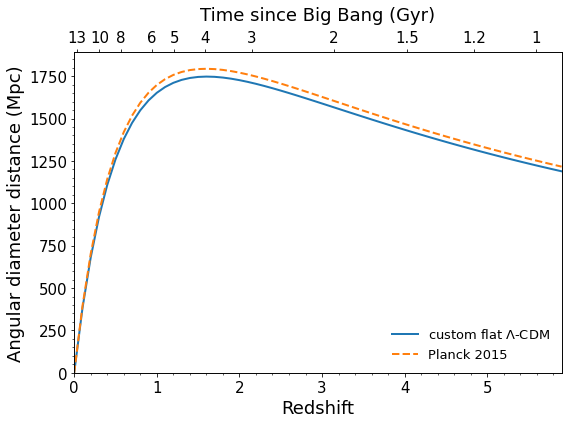

In [63]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(zvals, dist_custom, linestyle='-', linewidth=2,  label=r'custom flat $\Lambda$-CDM')
ax.plot(zvals, dist_P15, linestyle='--',linewidth=2, label='Planck 2015')

ax2 = ax.twiny()
ax2.set_xticks(ageticks)
ax2.set_xticklabels(['{:g}'.format(age) for age in ages.value],fontsize=15)

zmin, zmax = 0.0, 5.9
ax.set_xlim(zmin, zmax)
ax2.set_xlim(zmin, zmax)

ax2.set_xlabel('Time since Big Bang (Gyr)',fontsize=18, labelpad=10)
ax.set_xlabel('Redshift',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylabel('Angular diameter distance (Mpc)',fontsize=18)
ax.set_ylim(0, 1890)
ax.minorticks_on()

ax.legend(loc='lower right',frameon=False,fontsize=13)
plt.tight_layout()